Detected text: 2


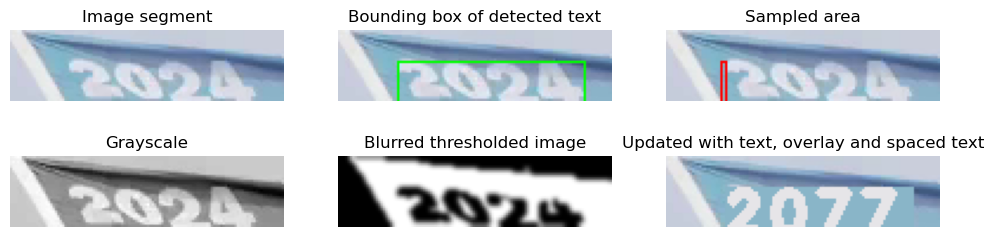

Updated cropped image saved as segment_with_replaced_Text.png


In [1]:
# Code listing: A_Aug_OCR_Trial_on_Segment
# Initial trials on a cropped image and disaplying previews of intermediate stages 

import cv2
import pytesseract
import numpy as np
from matplotlib import pyplot as plt

# Other potential improvements not implemented yet 
# Set the text to the colour of the detected text 
# Angle the overlaid bounding box to the same angle as the detected text  - NOT DONE - Experimented and removed 
image_path = r"D:/FlagDetectionDatasets/a_pSDS/new/croppedflag5.png"
cropped_img = cv2.imread(image_path)  # Cropped image for processing

inputimg = cropped_img.copy() # For showing boundary boxes 
image_bb = cropped_img.copy()  # To show the text bounding box
image_smp = cropped_img.copy()  # For Colour Sampling area 
overlay_img = cropped_img.copy() # Overlay image for blending

# Get the original dimensions
height, width = cropped_img.shape[:2]
overlay_alpha =  1 # Transparency factor (0: transparent, 1: opaque

# Calculate the new dimensions (1/4 of original dimensions)
#new_width = width // 3
#new_height = height // 6

# Crop the top-left corner of the image to fit the new dimensions
#cropped_img = img[0:new_height, 0:new_width]

# Replace the text with new text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.75  # Adjust to fit the new text in the bounding box
thickness = 3
new_text = "2077" 
text_color = (232, 229, 230)  # An off white for the text in B, G, R) 

# Preprocess the image
gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
# Apply manual thresholding
_, thresh = cv2.threshold(gray, 200, 180, cv2.THRESH_BINARY_INV)
# Apply Gaussian blur after thresholding
blurred = cv2.GaussianBlur(thresh, (5, 5), 0)

# OCR to extract and print detected text
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'

#text = pytesseract.image_to_string(blurred, config=custom_config)
text = pytesseract.image_to_string(blurred, config=custom_config).strip()
# Output the detected text
print(f"Detected text: {text}")

# Detect bounding boxes around individual digits
boxes = pytesseract.image_to_boxes(blurred, config=custom_config)

# Parse the bounding boxes and replace detected text
h, w = blurred.shape
for box in boxes.splitlines():
    b = box.split()
    detected_text = b[0]  # Detected character
    x1, y1, x2, y2 = int(b[1]), h - int(b[2]), int(b[3]), h - int(b[4])  # Convert coordinates

    # Calculate the position to align the new "7" with the left of the bounding box
    text_x = 0  # Align the left of the text with the left of the bounding box
    text_y = 0  # Keep the vertical position at the top of the bounding box

    # Align the background color to take from the column to the left of the bounding box
    left_x = max(x1 - 2, 0)  # Prevent out of bounds
    background_color_region = cropped_img[y2:y1, left_x:x1]  # Sample from the column to the left of the bounding box in this case
    background_color1 = np.mean(background_color_region, axis=(0, 1)).astype(int)
 
    # Draw border around the sampled area
    cv2.rectangle(image_smp, (left_x, y1), (x1, y2), (0, 0, 255), 1)  # Red border
    # Fill the bounding box with background color sampled from the left
    cv2.rectangle(cropped_img, (x1, y2), (x2, y1), background_color1.tolist(), -3)
    cv2.rectangle(image_bb, (x1, y2), (x2, y1), (0, 255, 0), 1)  # Box around text area 
  
    ## Space the text horizontally within the detected text bounding box 
    box_width = x2 - x1
    box_height = y2 - y1
    # Calculate the spacing between each character to stretch the text
    char_spacing = box_width // len(new_text) 

    # Start drawing each character of the new text, spaced out to fill the bounding box
    #current_x = x1  # Start at the left boundary of the bounding box
    text_size = cv2.getTextSize(new_text, font, font_scale, thickness)[0]
    text_x = x1  # Start the text at the left boundary of the bounding box
    text_y = y1 - (y1 - y2 - text_size[1]) // 2  # Center the text vertically

    # Start drawing each character of the new text, spaced out to fill the bounding box
    current_x = x1  # Start at the left boundary of the bounding box
    for char in new_text:
        # Vertical position to center the character within the bounding box
        char_y = y1 - (y1 - y2 - text_size[1]) // 2  # Center the text vertically 
        cv2.putText(cropped_img, char, (current_x, char_y), font, font_scale, text_color, thickness)
        # Move the current_x position for the next character, with the calculated spacing
        current_x += char_spacing

# Blended overlay is not working. Likely need to do it outside the loop 
# Extract ROI from both cropped_img and overlay_img and blend
#roi_cropped_img = cropped_img[y2:y1, x1:x2]
#roi_overlay_img = overlay_img[y2:y1, x1:x2]
# Check ROI dimensions
#if roi_cropped_img.size == 0 or roi_overlay_img.size == 0:
#    print(f"Invalid ROI: ({x1}, {y1}), ({x2}, {y2})")
#else:
# Blend the ROI
#    blended_overlay = cv2.addWeighted(roi_overlay_img, overlay_alpha, roi_cropped_img, 1 - overlay_alpha, 0)
# Update the original cropped image
#cropped_img[max(0, y2):min(height, y1), max(0, x1):min(width, x2)] = blended_overlay

# Display the processed images
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1 )
plt.imshow(cv2.cvtColor(inputimg, cv2.COLOR_BGR2RGB))
plt.title("Image segment")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(image_bb, cv2.COLOR_BGR2RGB))
plt.title("Bounding box of detected text")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(image_smp, cv2.COLOR_BGR2RGB))
plt.title("Sampled area")
plt.axis('off')

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title("Blurred thresholded image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.title("Updated with text, overlay and spaced text")
plt.axis('off')

#plt.subplot(1, 3, 3)
#plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
#plt.title("Spaced text and blended overlay")
#plt.axis('off')    
plt.show()

# Save the updated image for reference
output_path = "segment_with_replaced_Text.png"
cv2.imwrite(output_path, cropped_img)
print(f"Updated cropped image saved as {output_path}")
